## Predicting student exam scores. With Student Performance dataset on kaggle. We will EDA, then split the data and apply machine learning model (Linear Regression, Decision Tree, Random Forest, XGBoost, SVM) to comment which model is best for the data


In [1]:
#Import Libaries
import pandas as pd
import numpy as np
from scipy.stats import skew
import seaborn as sns
import matplotlib.pyplot as plt
from typing import Dict, List, Tuple

### 1. Read data description and summary



In [2]:
with open("/kaggle/input/house-prices-advanced-regression-techniques/data_description.txt", "r") as f:
    content = f.read()
print(content)  

MSSubClass: Identifies the type of dwelling involved in the sale.	

        20	1-STORY 1946 & NEWER ALL STYLES
        30	1-STORY 1945 & OLDER
        40	1-STORY W/FINISHED ATTIC ALL AGES
        45	1-1/2 STORY - UNFINISHED ALL AGES
        50	1-1/2 STORY FINISHED ALL AGES
        60	2-STORY 1946 & NEWER
        70	2-STORY 1945 & OLDER
        75	2-1/2 STORY ALL AGES
        80	SPLIT OR MULTI-LEVEL
        85	SPLIT FOYER
        90	DUPLEX - ALL STYLES AND AGES
       120	1-STORY PUD (Planned Unit Development) - 1946 & NEWER
       150	1-1/2 STORY PUD - ALL AGES
       160	2-STORY PUD - 1946 & NEWER
       180	PUD - MULTILEVEL - INCL SPLIT LEV/FOYER
       190	2 FAMILY CONVERSION - ALL STYLES AND AGES

MSZoning: Identifies the general zoning classification of the sale.
		
       A	Agriculture
       C	Commercial
       FV	Floating Village Residential
       I	Industrial
       RH	Residential High Density
       RL	Residential Low Density
       RP	Residential Low Density Park 
       RM

### 2. load dataset and Explore data



In [3]:
train_df = pd.read_csv("/kaggle/input/house-prices-advanced-regression-techniques/train.csv")
test_df = pd.read_csv("/kaggle/input/house-prices-advanced-regression-techniques/test.csv")

In [4]:
#Shape dataset
print("Train shape:", train_df.shape)
print("Test shape:", test_df.shape)

Train shape: (1460, 81)
Test shape: (1459, 80)


In [5]:
train_df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [6]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [7]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1459 entries, 0 to 1458
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1459 non-null   int64  
 1   MSSubClass     1459 non-null   int64  
 2   MSZoning       1455 non-null   object 
 3   LotFrontage    1232 non-null   float64
 4   LotArea        1459 non-null   int64  
 5   Street         1459 non-null   object 
 6   Alley          107 non-null    object 
 7   LotShape       1459 non-null   object 
 8   LandContour    1459 non-null   object 
 9   Utilities      1457 non-null   object 
 10  LotConfig      1459 non-null   object 
 11  LandSlope      1459 non-null   object 
 12  Neighborhood   1459 non-null   object 
 13  Condition1     1459 non-null   object 
 14  Condition2     1459 non-null   object 
 15  BldgType       1459 non-null   object 
 16  HouseStyle     1459 non-null   object 
 17  OverallQual    1459 non-null   int64  
 18  OverallC

#### Id is varible identifier because remove it


In [8]:
train_df = train_df.drop(columns=['Id'])
test_df = test_df.drop(columns=['Id'])

#### MSSubCLass In terms of statistical significance, it is a categorical variable.

In [9]:
train_df['MSSubClass'] = train_df['MSSubClass'].astype('object')
test_df['MSSubClass'] = test_df['MSSubClass'].astype('object')

#### handle missing values

In [10]:
import pandas as pd
import numpy as np
from typing import Dict, List, Tuple

def safe_imputer_sync(df_to_fit: pd.DataFrame, df_to_transform: pd.DataFrame) -> pd.DataFrame:
    """
    Synchronously imputes missing data in df_to_transform (TEST) using imputation parameters 
    (Median/Mode) learned from df_to_fit (TRAIN).

    Args:
        df_to_fit (pd.DataFrame): The DataFrame used to learn Median/Mode values (TRAIN).
        df_to_transform (pd.DataFrame): The DataFrame that needs imputation (TEST).
    
    Returns:
        pd.DataFrame: The DataFrame after imputation.
    """
    
    df_transformed = df_to_transform.copy()
    
    # 1. HANDLE NUMERIC COLUMNS - USE MEDIAN
    # Learn numeric columns from the fit set
    numeric_cols = df_to_fit.select_dtypes(include=np.number).columns
    
    for col in numeric_cols:
        # Check if the column exists in the transformed set and has missing values
        if col in df_transformed.columns and df_transformed[col].isnull().any():
            # Learn the parameter (Median) ONLY from the FIT set
            median_value = df_to_fit[col].median()
            
            # Apply imputation to the TRANSFORM set
            df_transformed[col] = df_transformed[col].fillna(median_value)
            print(f"✅ Filled '{col}' with Median from TRAIN ({median_value:.2f}).")
        elif col not in df_transformed.columns:
             # Handle case where a numerical column is missing in the test set (rare after alignment)
             pass


    # 2. HANDLE CATEGORICAL COLUMNS - USE "NONE"
    # Learn categorical columns from the fit set
    categorical_cols = df_to_fit.select_dtypes(include=['object', 'category']).columns
    
    for col in categorical_cols:
        if col in df_transformed.columns and df_transformed[col].isnull().any():
            # Apply imputation with the constant "None"
            df_transformed[col] = df_transformed[col].fillna("None")
            print(f"✅ Filled '{col}' with 'None'.")
            
    print("\n--- SYNCHRONIZED IMPUTATION SUMMARY ---")
    print("✅ Missing Data filled successfully.")
    print(f"Total Missing Values remaining: {df_transformed.isnull().sum().sum()}")
    return df_transformed

# --- CORRECT AND SAFE USAGE ---

# Step 1: Process the TRAIN set (Learning parameters from itself)
train_df_imputed = safe_imputer_sync(df_to_fit=train_df, df_to_transform=train_df)

# Step 2: Process the TEST set (Learning parameters from the processed TRAIN set)
test_df_imputed = safe_imputer_sync(df_to_fit=train_df_imputed, df_to_transform=test_df)

✅ Filled 'LotFrontage' with Median from TRAIN (69.00).
✅ Filled 'MasVnrArea' with Median from TRAIN (0.00).
✅ Filled 'GarageYrBlt' with Median from TRAIN (1980.00).
✅ Filled 'Alley' with 'None'.
✅ Filled 'MasVnrType' with 'None'.
✅ Filled 'BsmtQual' with 'None'.
✅ Filled 'BsmtCond' with 'None'.
✅ Filled 'BsmtExposure' with 'None'.
✅ Filled 'BsmtFinType1' with 'None'.
✅ Filled 'BsmtFinType2' with 'None'.
✅ Filled 'Electrical' with 'None'.
✅ Filled 'FireplaceQu' with 'None'.
✅ Filled 'GarageType' with 'None'.
✅ Filled 'GarageFinish' with 'None'.
✅ Filled 'GarageQual' with 'None'.
✅ Filled 'GarageCond' with 'None'.
✅ Filled 'PoolQC' with 'None'.
✅ Filled 'Fence' with 'None'.
✅ Filled 'MiscFeature' with 'None'.

--- SYNCHRONIZED IMPUTATION SUMMARY ---
✅ Missing Data filled successfully.
Total Missing Values remaining: 0
✅ Filled 'LotFrontage' with Median from TRAIN (69.00).
✅ Filled 'MasVnrArea' with Median from TRAIN (0.00).
✅ Filled 'BsmtFinSF1' with Median from TRAIN (383.50).
✅ Filled 

### House Price Distribution
##### Now let us take a look at how the house prices are distributed.

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64


/tmp/ipykernel_13/1859412649.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(train_df['SalePrice'], color='g', bins=100, hist_kws={'alpha': 0.4});
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


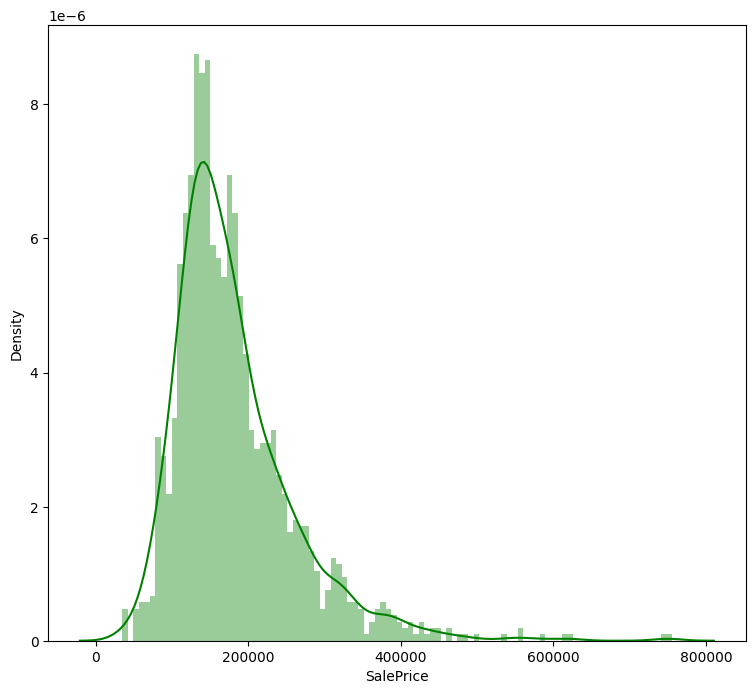

In [11]:
print(train_df['SalePrice'].describe())
plt.figure(figsize=(9, 8))
sns.distplot(train_df['SalePrice'], color='g', bins=100, hist_kws={'alpha': 0.4});

In [12]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1460 non-null   object 
 1   MSZoning       1460 non-null   object 
 2   LotFrontage    1201 non-null   float64
 3   LotArea        1460 non-null   int64  
 4   Street         1460 non-null   object 
 5   Alley          91 non-null     object 
 6   LotShape       1460 non-null   object 
 7   LandContour    1460 non-null   object 
 8   Utilities      1460 non-null   object 
 9   LotConfig      1460 non-null   object 
 10  LandSlope      1460 non-null   object 
 11  Neighborhood   1460 non-null   object 
 12  Condition1     1460 non-null   object 
 13  Condition2     1460 non-null   object 
 14  BldgType       1460 non-null   object 
 15  HouseStyle     1460 non-null   object 
 16  OverallQual    1460 non-null   int64  
 17  OverallCond    1460 non-null   int64  
 18  YearBuil

### handle ordinal value.

In [13]:
import pandas as pd
from typing import Dict, List

def apply_complete_ordinal_encoding(df: pd.DataFrame) -> pd.DataFrame:
    """
    Áp dụng Mã hóa Thứ tự (Ordinal Encoding) cho 17 cột phân cấp chất lượng/thứ bậc.
    Cột OverallQual và OverallCond đã là số và được giữ nguyên.
    
    Giả định: Tất cả các giá trị thiếu (NA) trong các cột này đã được điền bằng chuỗi 'None'.

    Args:
        df (pd.DataFrame): DataFrame đầu vào.
        
    Returns:
        pd.DataFrame: DataFrame với các cột Ordinal đã được mã hóa thành số.
    """
    
    df_encoded = df.copy()

    # 1. ĐỊNH NGHĨA CÁC ÁNH XẠ (Mapping Definitions)

    # Thang điểm Chất lượng/Tình trạng Chung (Po/Fa/TA/Gd/Ex) - 6 cấp độ (0-5)
    # Áp dụng cho hầu hết các cột chất lượng/tình trạng (bao gồm 'None'=0)
    qual_cond_mapping_6 = {'None': 0, 'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5}
    
    # LotShape (Irregular -> Regular)
    lot_shape_mapping = {'IR3': 1, 'IR2': 2, 'IR1': 3, 'Reg': 4, 'None': 0} # 4 điểm
    
    # Utilities (Worst -> Best)
    utilities_mapping = {'ELO': 1, 'NoSeWa': 2, 'NoSewr': 3, 'AllPub': 4, 'None': 0} # 4 điểm
    
    # LandSlope (Severe -> Gentle)
    land_slope_mapping = {'Sev': 1, 'Mod': 2, 'Gtl': 3, 'None': 0} # 3 điểm
    
    # BsmtExposure (No Exposure -> Good Exposure)
    bsmt_exposure_mapping = {'None': 0, 'No': 1, 'Mn': 2, 'Av': 3, 'Gd': 4} # 5 điểm

    # BsmtFinType (Unfinished -> Good Living Quarters)
    bsmt_fin_mapping_7 = {'None': 0, 'Unf': 1, 'LwQ': 2, 'Rec': 3, 'BLQ': 4, 'ALQ': 5, 'GLQ': 6} # 7 điểm
    
    # GarageFinish (Unfinished -> Finished)
    garage_finish_mapping = {'None': 0, 'Unf': 1, 'RFn': 2, 'Fin': 3} # 4 điểm
    
    # Functional Rating (Salvage -> Typical) - 8 cấp độ
    functional_mapping = {
        'Sal': 1, 'Sev': 2, 'Maj2': 3, 'Maj1': 4, 
        'Mod': 5, 'Min2': 6, 'Min1': 7, 'Typ': 8
    }

    # ----------------------------------------------------------------------
    # 2. COLUMN APPLICATION LIST (17 Cột cần mã hóa)
    # ----------------------------------------------------------------------

    column_mappings: List[tuple[str, Dict[str, int]]] = [
        # Quality/Condition - 6-Point Scale
        ('ExterQual', qual_cond_mapping_6), ('ExterCond', qual_cond_mapping_6),
        ('HeatingQC', qual_cond_mapping_6), ('KitchenQual', qual_cond_mapping_6),
        ('BsmtQual', qual_cond_mapping_6), ('BsmtCond', qual_cond_mapping_6),
        ('FireplaceQu', qual_cond_mapping_6), ('PoolQC', qual_cond_mapping_6),
        ('GarageQual', qual_cond_mapping_6), ('GarageCond', qual_cond_mapping_6),
        
        # Specific Mappings
        ('LotShape', lot_shape_mapping),
        ('Utilities', utilities_mapping),
        ('LandSlope', land_slope_mapping),
        ('BsmtExposure', bsmt_exposure_mapping),
        ('BsmtFinType1', bsmt_fin_mapping_7),
        ('BsmtFinType2', bsmt_fin_mapping_7),
        ('GarageFinish', garage_finish_mapping),
        ('Functional', functional_mapping),
    ]
    
    print("--- STARTING CUSTOM ORDINAL ENCODING ---")
    
    for col, mapping in column_mappings:
        if col in df_encoded.columns:
            # Áp dụng mapping, fillna(0) xử lý mọi giá trị không được ánh xạ.
            df_encoded[col] = df_encoded[col].map(mapping).fillna(0).astype(int)
            print(f"✅ Encoded: {col}")
        else:
             print(f"⚠️ Column '{col}' not found. Skipping.")

    # 3. Giữ nguyên OverallQual và OverallCond vì chúng đã là số (int)
    print("--- ORDINAL ENCODING COMPLETE ---")
    
    return df_encoded

# --- VÍ DỤ SỬ DỤNG ---
train_df_ordinal_encoded = apply_complete_ordinal_encoding(train_df_imputed)
test_df_ordinal_encoded = apply_complete_ordinal_encoding(test_df_imputed)

--- STARTING CUSTOM ORDINAL ENCODING ---
✅ Encoded: ExterQual
✅ Encoded: ExterCond
✅ Encoded: HeatingQC
✅ Encoded: KitchenQual
✅ Encoded: BsmtQual
✅ Encoded: BsmtCond
✅ Encoded: FireplaceQu
✅ Encoded: PoolQC
✅ Encoded: GarageQual
✅ Encoded: GarageCond
✅ Encoded: LotShape
✅ Encoded: Utilities
✅ Encoded: LandSlope
✅ Encoded: BsmtExposure
✅ Encoded: BsmtFinType1
✅ Encoded: BsmtFinType2
✅ Encoded: GarageFinish
✅ Encoded: Functional
--- ORDINAL ENCODING COMPLETE ---
--- STARTING CUSTOM ORDINAL ENCODING ---
✅ Encoded: ExterQual
✅ Encoded: ExterCond
✅ Encoded: HeatingQC
✅ Encoded: KitchenQual
✅ Encoded: BsmtQual
✅ Encoded: BsmtCond
✅ Encoded: FireplaceQu
✅ Encoded: PoolQC
✅ Encoded: GarageQual
✅ Encoded: GarageCond
✅ Encoded: LotShape
✅ Encoded: Utilities
✅ Encoded: LandSlope
✅ Encoded: BsmtExposure
✅ Encoded: BsmtFinType1
✅ Encoded: BsmtFinType2
✅ Encoded: GarageFinish
✅ Encoded: Functional
--- ORDINAL ENCODING COMPLETE ---


In [14]:
import pandas as pd
from typing import List

def apply_nominal_ohe_after_ordinal_filtered(df: pd.DataFrame) -> pd.DataFrame:
    """
    Loại trừ các cột đã được Ordinal Encoded (vì chúng đã là số) 
    và áp dụng One-Hot Encoding (OHE) cho tất cả các biến phân loại danh nghĩa (Nominal) còn lại.

    Args:
        df (pd.DataFrame): DataFrame sau khi đã Ordinal Encoded.
    
    Returns:
        pd.DataFrame: DataFrame chỉ chứa dữ liệu số (đã được mã hóa).
    """
    
    df_encoded = df.copy()
    
    # 1. Liệt kê các cột Ordinal đã được mã hóa (đã chuyển sang int/float)
    # Các cột này KHÔNG cần OHE.
    ordinal_cols_encoded = [
        'ExterQual', 'ExterCond', 'HeatingQC', 'KitchenQual', 
        'BsmtQual', 'BsmtCond', 'FireplaceQu', 'PoolQC',
        'GarageQual', 'GarageCond', 'LotShape', 'Utilities', 
        'LandSlope', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
        'Functional', 'Fence', 'GarageFinish',
    ]
    
    # 2. Xác định các cột Nominal còn sót lại
    # Lọc tất cả các cột kiểu 'object' còn lại. 
    # Các cột Ordinal đã chuyển sang int/float sẽ tự động bị loại khỏi danh sách này.
    nominal_cols_to_ohe = df_encoded.select_dtypes(include=['object']).columns
    
    if nominal_cols_to_ohe.empty:
        print("Cảnh báo: Không tìm thấy cột phân loại Nominal nào để mã hóa. Dữ liệu đã là số.")
        return df_encoded
        
    print("--- BẮT ĐẦU ONE-HOT ENCODING (NOMINAL FEATURES) ---")
    print(f"Các cột Nominal được mã hóa: {nominal_cols_to_ohe.tolist()}")
    
    # 3. Áp dụng OHE
    # drop_first=True: Loại bỏ cột đầu tiên để tránh đa cộng tuyến hoàn hảo
    df_final = pd.get_dummies(df_encoded, columns=nominal_cols_to_ohe, drop_first=True)
    
    print("--- OHE HOÀN TẤT ---")
    print(f"Số lượng cột MỚI: {df_final.shape[1]}")
    print("✅ DataFrame hiện chỉ chứa dữ liệu số, sẵn sàng cho Chuẩn hóa (Scaling).")
    
    return df_final

# --- VÍ DỤ SỬ DỤNG ---
# Giả định: train_df_ordinal_encoded là DataFrame của bạn
train_df_final_encoded = apply_nominal_ohe_after_ordinal_filtered(train_df_ordinal_encoded)


--- BẮT ĐẦU ONE-HOT ENCODING (NOMINAL FEATURES) ---
Các cột Nominal được mã hóa: ['MSSubClass', 'MSZoning', 'Street', 'Alley', 'LandContour', 'LotConfig', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'Foundation', 'Heating', 'CentralAir', 'Electrical', 'GarageType', 'PavedDrive', 'Fence', 'MiscFeature', 'SaleType', 'SaleCondition']
--- OHE HOÀN TẤT ---
Số lượng cột MỚI: 221
✅ DataFrame hiện chỉ chứa dữ liệu số, sẵn sàng cho Chuẩn hóa (Scaling).


In [15]:
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np

def apply_final_scaling(df_final_encoded: pd.DataFrame, target_col: str = 'SalePrice_Log') -> pd.DataFrame:
    """
    Áp dụng StandardScaler cho tất cả các cột số liên tục và Ordinal, 
    bỏ qua các cột nhị phân (OHE) và biến mục tiêu.

    Args:
        df_final_encoded (pd.DataFrame): DataFrame đã được mã hóa đầy đủ.
        target_col (str): Tên cột biến mục tiêu.
    
    Returns:
        pd.DataFrame: DataFrame với các features đã được chuẩn hóa.
    """
    
    df_scaled = df_final_encoded.copy()
    
    # 1. Xác định Cột Cần Scaling
    # Lọc tất cả các cột số
    numeric_cols = df_scaled.select_dtypes(include=np.number).columns
    
    # Loại bỏ biến mục tiêu khỏi danh sách
    cols_to_check = numeric_cols.drop(target_col, errors='ignore').tolist()
    
    # Chỉ giữ lại các cột KHÔNG PHẢI NHỊ PHÂN (cột có nhiều hơn 2 giá trị duy nhất)
    # Đây là các biến liên tục (log-transformed) và Ordinal
    final_cols_to_scale = [col for col in cols_to_check if df_scaled[col].nunique() > 2]
    
    # 2. Thực hiện Scaling
    scaler = StandardScaler()
    
    # FIT và TRANSFORM chỉ trên các cột đã lọc
    df_scaled[final_cols_to_scale] = scaler.fit_transform(df_scaled[final_cols_to_scale])
    
    print("--- SCALING HOÀN TẤT ---")
    print(f"✅ Đã áp dụng StandardScaler cho {len(final_cols_to_scale)} cột (Ordinal và Continuous).")
    
    return df_scaled

# --- VÍ DỤ SỬ DỤNG ---
train_df_final_scaled = apply_final_scaling(train_df_final_encoded)

--- SCALING HOÀN TẤT ---
✅ Đã áp dụng StandardScaler cho 53 cột (Ordinal và Continuous).


In [16]:
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
from typing import Tuple

def split_train_validation(df_scaled: pd.DataFrame, target_col: str = 'SalePrice', test_size: float = 0.2, random_state: int = 42) -> Tuple[pd.DataFrame, pd.DataFrame, pd.Series, pd.Series]:
    """
    Chia tập dữ liệu huấn luyện (train set) thành tập huấn luyện và tập thẩm định (validation set).

    Args:
        df_scaled (pd.DataFrame): DataFrame đã được chuẩn hóa (chứa cả features và target).
        target_col (str): Tên cột biến mục tiêu (SalePrice_Log).
        test_size (float): Tỷ lệ dữ liệu dành cho tập thẩm định (validation set).
        random_state (int): Seed để đảm bảo tính tái lập.

    Returns:
        Tuple: (X_train, X_val, y_train, y_val)
    """
    
    # 1. Tách Features (X) và Target (y)
    X = df_scaled.drop(columns=[target_col])
    y = df_scaled[target_col]
    
    # 2. Chia tập dữ liệu
    # Sử dụng train_test_split. Ở đây, 'test' đại diện cho Validation
    X_train, X_val, y_train, y_val = train_test_split(
        X, y, test_size=test_size, random_state=random_state
    )
    
    print("--- CHIA TẬP DỮ LIỆU HOÀN TẤT ---")
    print(f"Kích thước Tập Huấn luyện (X_train): {X_train.shape}")
    print(f"Kích thước Tập Thẩm định (X_val): {X_val.shape}")
    print(f"Tỷ lệ chia: {1 - test_size}:{test_size} (Huấn luyện:Thẩm định)")
    
    return X_train, X_val, y_train, y_val

# --- VÍ DỤ SỬ DỤNG ---
# Giả định: train_df_final_scaled đã được định nghĩa
X_train, X_val, y_train, y_val = split_train_validation(train_df_final_scaled, test_size=0.2)

--- CHIA TẬP DỮ LIỆU HOÀN TẤT ---
Kích thước Tập Huấn luyện (X_train): (1168, 220)
Kích thước Tập Thẩm định (X_val): (292, 220)
Tỷ lệ chia: 0.8:0.2 (Huấn luyện:Thẩm định)


In [17]:
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
import numpy as np
import pandas as pd

# Ứng cử viên Mô hình
models = {
    "Lasso_Reg": Lasso(alpha=0.0005, max_iter=5000, random_state=42),
    "RandomForest": RandomForestRegressor(n_estimators=1000, max_depth=8, random_state=42, n_jobs=-1),
    "XGBoost": XGBRegressor(n_estimators=2000, learning_rate=0.01, max_depth=3, random_state=42, n_jobs=-1)
}

results = {}

print("--- BẮT ĐẦU HUẤN LUYỆN VÀ ĐÁNH GIÁ ---")

for name, model in models.items():
    # 1. Huấn luyện
    model.fit(X_train, y_train)
    
    # 2. Dự đoán trên tập Thẩm định (Validation)
    y_pred_val = model.predict(X_val)
    
    # 3. Đánh giá RMSE (trên thang đo Log)
    rmse_val_log = np.sqrt(mean_squared_error(y_val, y_pred_val))
    
    # 4. Chuyển đổi ngược về thang đo tiền tệ gốc để xem sai số thực tế
    # np.expm1(x) là phép nghịch đảo của np.log1p(x)
    y_val_original = np.expm1(y_val)
    y_pred_original = np.expm1(y_pred_val)
    rmse_val_original = np.sqrt(mean_squared_error(y_val_original, y_pred_original))
    
    results[name] = {
        "RMSE_Log": round(rmse_val_log, 4),
        "RMSE_Original": round(rmse_val_original, 2),
        "Model": model
    }
    
    print(f"✅ {name} hoàn tất.")

# Sắp xếp kết quả theo RMSE_Log thấp nhất
results_df = pd.DataFrame(results).T.sort_values(by="RMSE_Log")

print("\n--- TỔNG KẾT HIỆU SUẤT TRÊN TẬP VALIDATION ---")
print(results_df)

--- BẮT ĐẦU HUẤN LUYỆN VÀ ĐÁNH GIÁ ---
✅ Lasso_Reg hoàn tất.
✅ RandomForest hoàn tất.
✅ XGBoost hoàn tất.

--- TỔNG KẾT HIỆU SUẤT TRÊN TẬP VALIDATION ---
             RMSE_Log RMSE_Original  \
XGBoost        0.3229         66.05   
RandomForest   0.3693         73.87   
Lasso_Reg      0.3882         77.14   

                                                          Model  
XGBoost       XGBRegressor(base_score=None, booster=None, ca...  
RandomForest  (DecisionTreeRegressor(max_depth=8, max_featur...  
Lasso_Reg     Lasso(alpha=0.0005, max_iter=5000, random_stat...  
